# Description
Задача моделирования оттока клиентов телеком компании. Если клиент собирается уйти от нас то мы пытаемся удержать его.
В этом ноутбуке будет:
- EDA и выводы из него
- Постройка байзлайна и оценка качества байзлайна
- Эксперименты
- Финальная модель
- Выводы



Основная метрика - рок аук скор


In [1]:
import pandas as pd
from pathlib import Path
import sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Получаем абсолютный путь к src
parent_path = Path.cwd().parent
sys.path.append(str(parent_path))



In [2]:
# Импортируем модули
from scripts import config
from scripts.config import get_raw_data_path_and_target_name
from scripts.utils import change_dtype_col_to_numeric,  plot_stacked_bars

In [3]:
path, target = get_raw_data_path_and_target_name(path = '../configs/data_config.yaml')


In [4]:
df = pd.read_csv(path)
print(f"Данные загружены из: {path}")
print(f"Целевая переменная: {target}")
print(f"Размер данных: {df.shape}")

Данные загружены из: C:/Users/user/Desktop/Projects/Mentors/PredictingUserChurn/data/raw/raw_data.csv
Целевая переменная: Churn
Размер данных: (5282, 20)


In [5]:
df.isna().sum().sum()

np.int64(0)

# Много категориальных признков


In [6]:
df.dtypes 

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [7]:
change_dtype_col_to_numeric(df, 'TotalSpent')

In [8]:
df.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2291.390461,0.159409,0.262022
std,24.550326,30.176464,2267.079956,0.366092,0.439776
min,0.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.462500,401.587500,0.000000,0.000000
50%,29.000000,70.400000,1413.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


# Виден дисбаланс ключевой переменной

<Axes: >

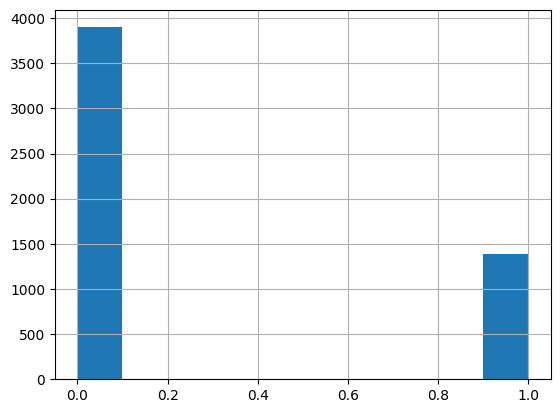

In [9]:
df.Churn.hist()

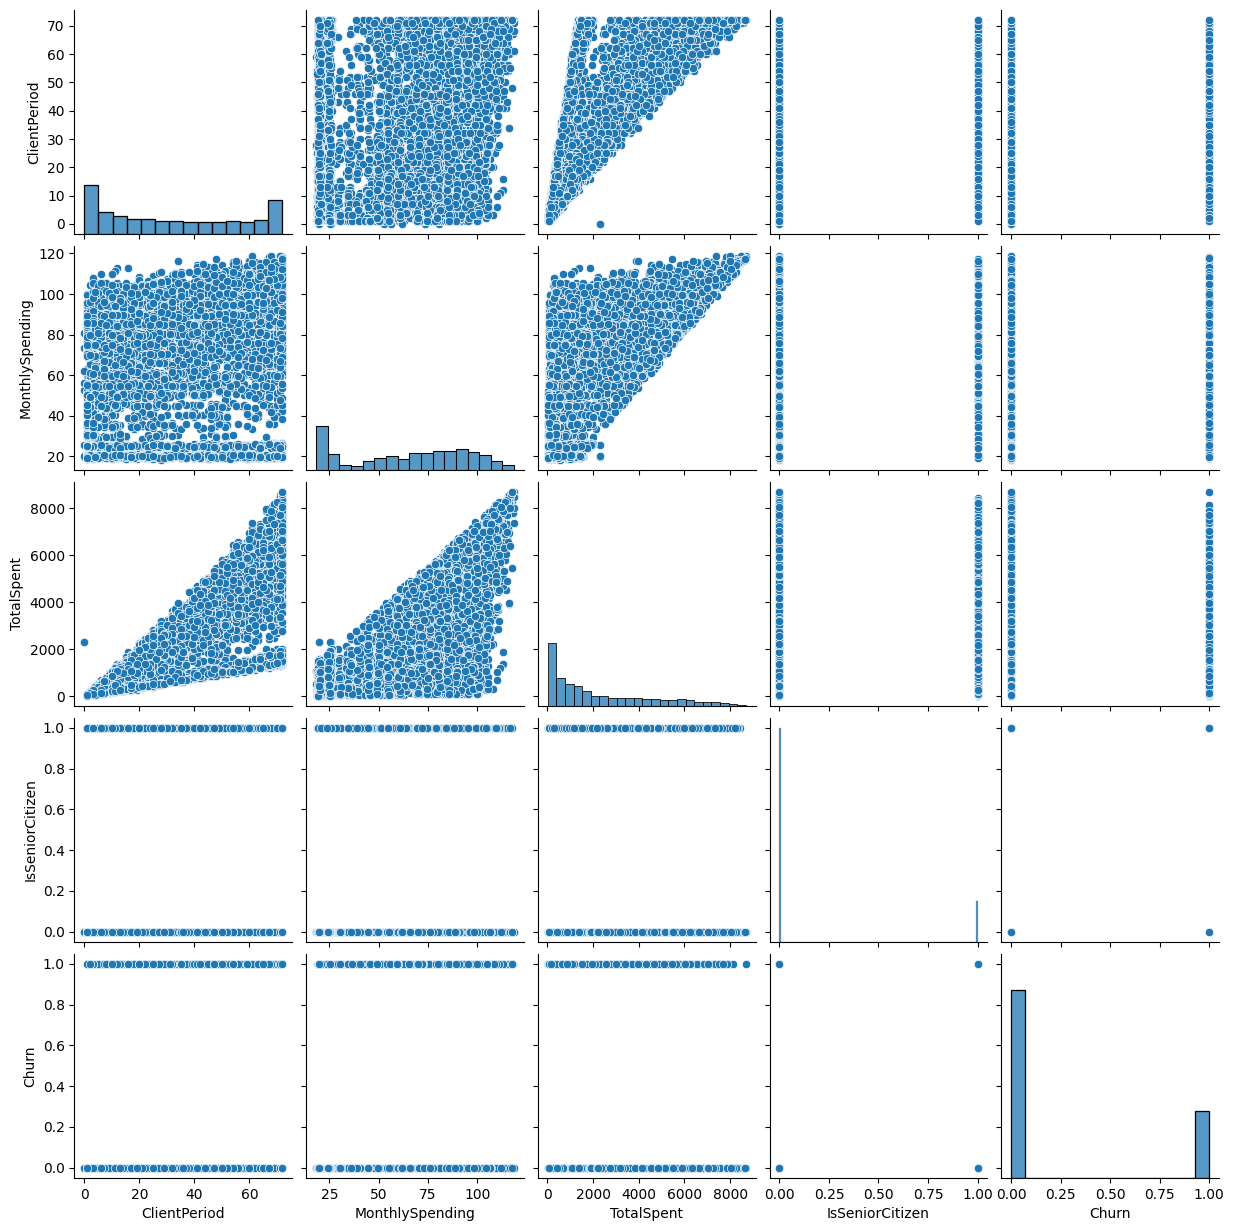

In [10]:
sns.pairplot(df)

# Явно видны корелляции между тратами

[Text(0.5, 0, 'ClientPeriod'),
 Text(1.5, 0, 'MonthlySpending'),
 Text(2.5, 0, 'TotalSpent'),
 Text(3.5, 0, 'IsSeniorCitizen'),
 Text(4.5, 0, 'Churn')]

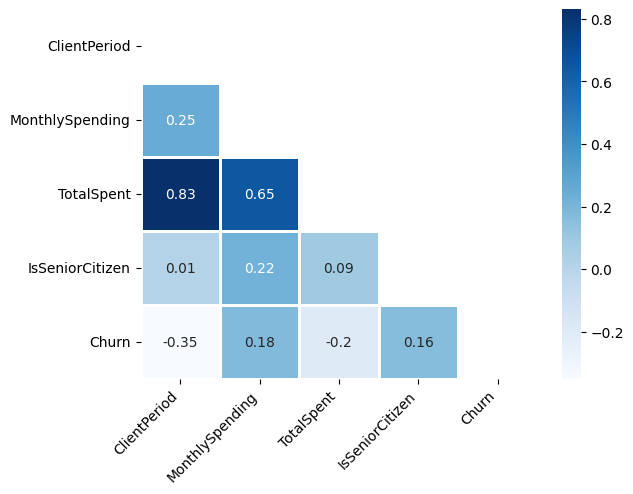

In [11]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
   df.corr(numeric_only=True).round(2),
    annot=True,
    mask = mask,
    cmap="Blues",  # использовать синию цветовую карту
    linewidth=2,  # пространство между клетками
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)

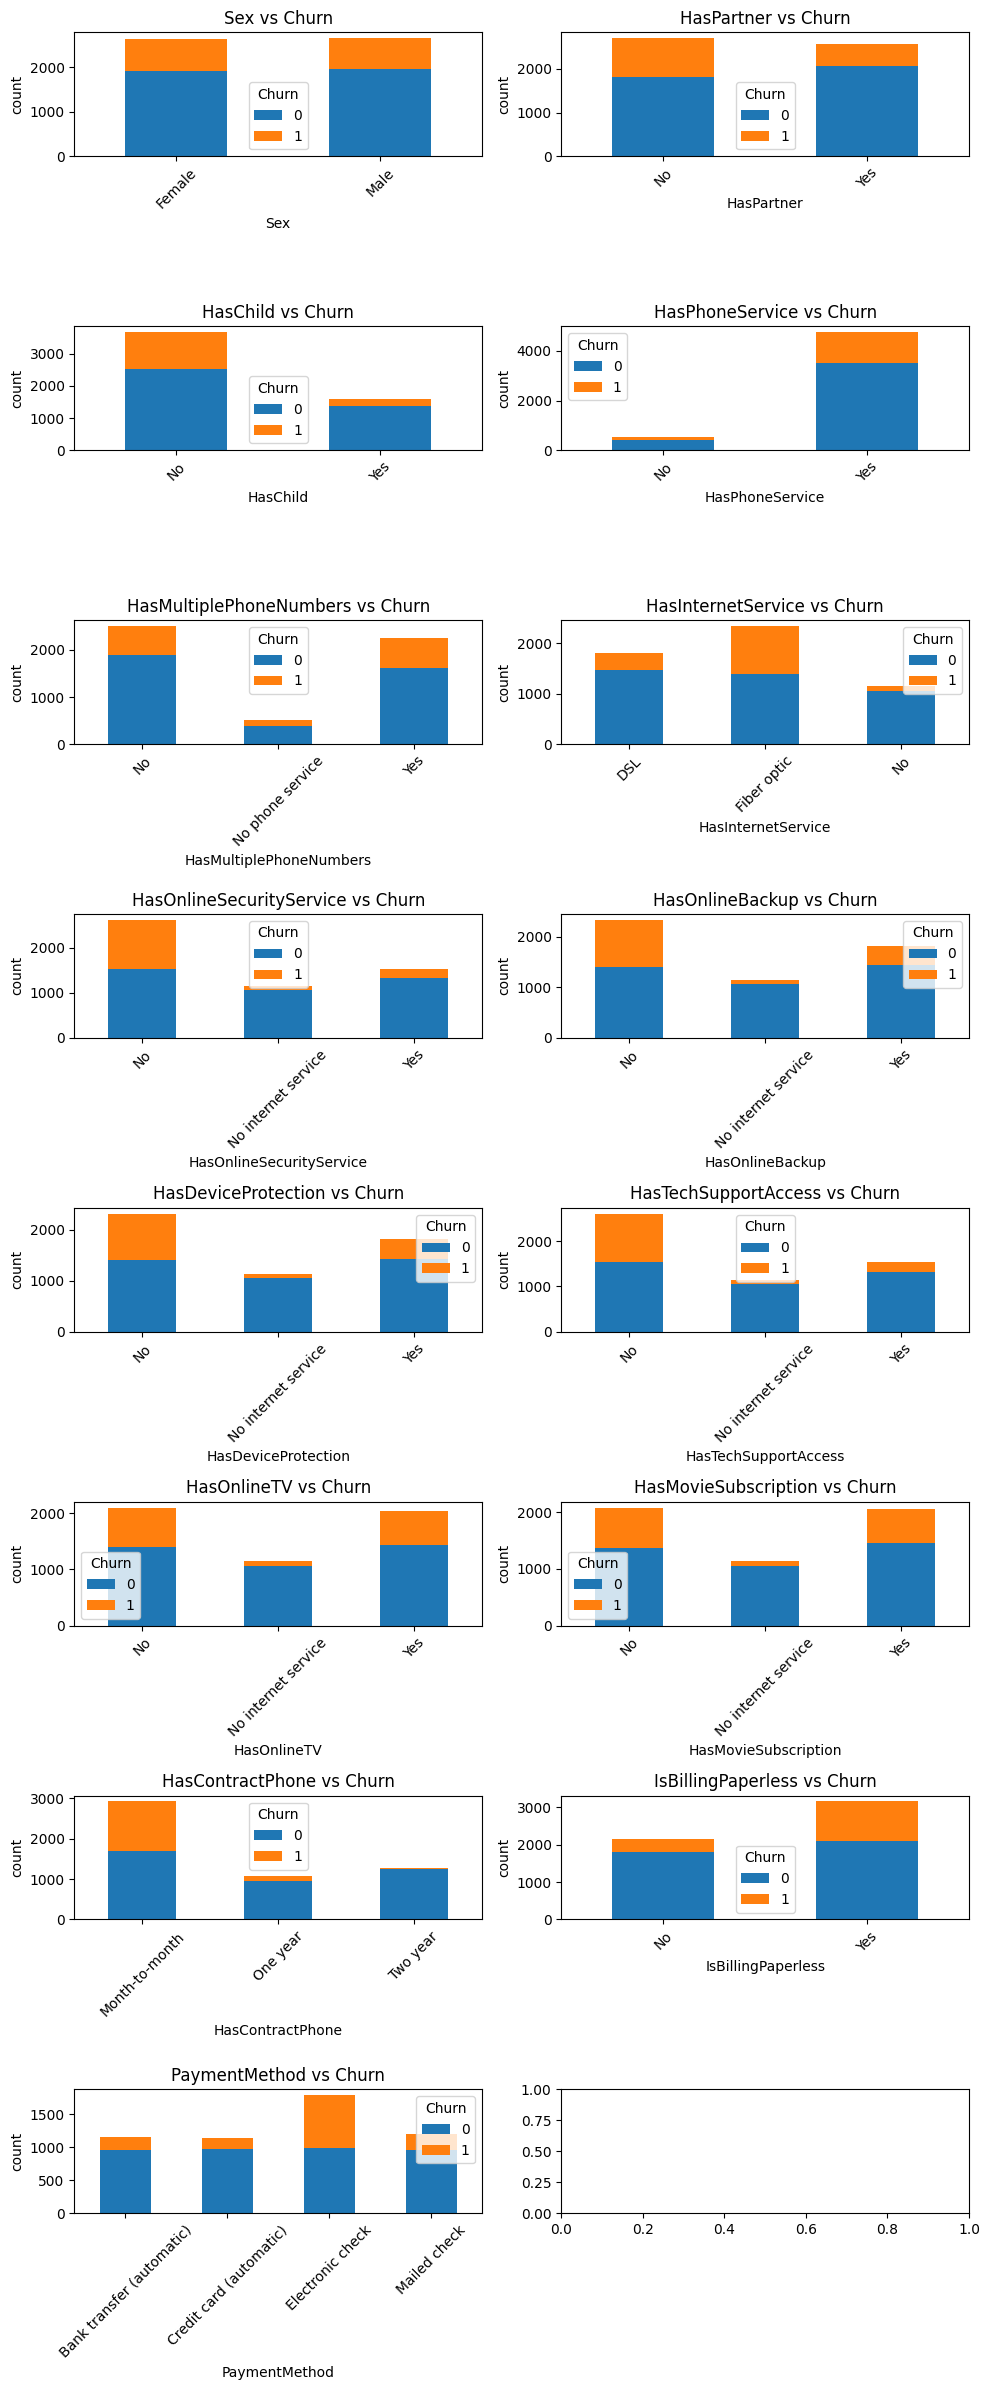

In [12]:
# Использование
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
plot_stacked_bars(df, categorical_cols, target)

In [13]:
df.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

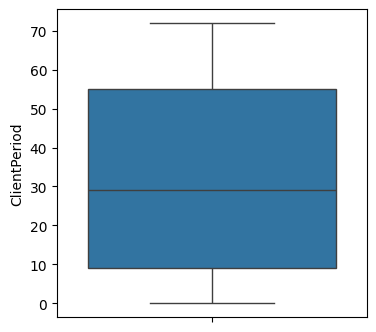

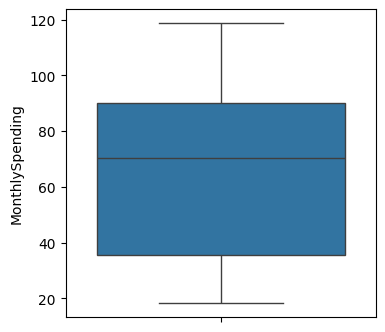

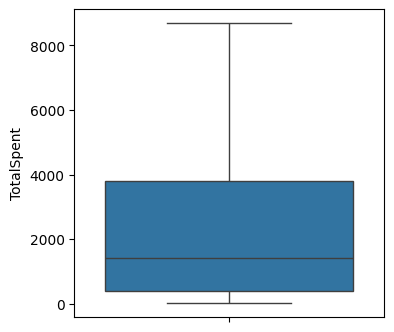

In [14]:
cols_for_boxplot = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

for i in cols_for_boxplot:
    plt. figure(figsize=(4, 4))
    sns.boxplot(df[i])
    plt.show()

# явных выбросов не видно

In [15]:
df.shape

(5282, 20)

In [16]:
df.drop_duplicates(inplace= True )

# Было несколько дубликатов, убрали


In [17]:
df.shape

(5268, 20)

# Попозже сделаем нормализацию первых 3 столбцов


# Выводы

Данные в целом чистые, нет особых выбросов. Пропусков в основном нет, были только в числовом столбце, где заменил на среднее. Найдено всего несколько дубликатов, которые убрали. Был один некорректный по типу столбец, сделал его числовым. По графикам распределений категориальных данных виден дисбаланс ключевой переменной, а также заметное количество положительных классов в payment method - electronic check и has contract phone - month to month


Добавлю пока одну фичу 
Spending_Change_Ratio: (MonthlySpending / TotalSpent). 

Этот признак показывает, какую долю от общих трат составляют текущие ежемесячные расходы. 


А также закодирую категориальные через one_hot_encoding

In [18]:


df['Spending_Change_Ratio'] = df.MonthlySpending /df.TotalSpent

df = pd.get_dummies(df, drop_first= True)

processed_path = config.get_processed_data_path(path = '../configs/data_config.yaml')

df['random_number'] = np.random.rand(df.shape[0])
df['random_normal'] = np.random.randn(df.shape[0])

df.to_csv(processed_path)

In [19]:
df

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,Spending_Change_Ratio,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,...,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,random_number,random_normal
0,55,19.50,1026.35,0,0,0.018999,True,True,True,True,...,True,False,True,False,False,False,False,True,0.992591,0.380167
1,72,25.85,1872.20,0,0,0.013807,True,True,False,True,...,True,False,False,True,False,True,False,False,0.866720,0.717384
2,1,75.90,75.90,0,1,1.000000,True,False,False,True,...,False,False,False,False,True,False,True,False,0.601166,0.688786
3,32,79.30,2570.00,1,0,0.030856,False,True,False,True,...,False,False,False,False,False,False,False,True,0.698408,-1.445610
4,60,115.25,6758.45,0,0,0.017053,False,True,True,True,...,False,True,False,True,False,True,False,False,0.643678,-1.404105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,0,0,0.370055,True,False,False,False,...,False,False,False,False,False,False,True,False,0.765124,-0.751248
5278,50,44.45,2188.45,0,0,0.020311,True,True,False,False,...,False,False,True,False,True,False,False,False,0.808855,0.735302
5279,1,55.05,55.05,0,0,1.000000,True,False,False,True,...,False,False,False,False,False,False,False,True,0.847250,0.416238
5280,29,76.00,2215.25,0,0,0.034308,False,False,False,True,...,False,False,False,False,True,True,False,False,0.875708,-0.166125


# Продолжение в experiments.ipynb
